In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Import necessary Surprise Libraries

In [2]:
from surprise import KNNWithMeans
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from collections import defaultdict
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

# 1. Read and Explore the Data set

In [3]:
df = pd.read_csv("ratings_Electronics.csv", names=['userId', 'productId', 'rating','timestamp'])

In [4]:
df.shape

(7824482, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
rating       float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [6]:
df.isna().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [7]:
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [8]:
print("Unique Products : ", len(df['productId'].unique()))

Unique Products :  476002


In [9]:
print("Unique Users : ", len(df['userId'].unique()))

Unique Users :  4201696


In [10]:
print("Unique Ratings : ", df['rating'].unique())

Unique Ratings :  [5. 1. 3. 2. 4.]


In [11]:
print(" Products count by rating :\n ",df['rating'].value_counts())

 Products count by rating :
  5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: rating, dtype: int64


# 2. Identify the subset of data where users given atleast 50 ratings

In [12]:
df_grouped = df.groupby(by='userId',as_index=False).count()

In [13]:
df_grouped.head()

,userId,productId,rating,timestamp
0,A00000262KYZUE4J55XGL,1,1,1
1,A000063614T1OE0BUSKUT,2,2,2
2,A00009182QVLSWIGHLS1B,1,1,1
3,A00009661LC9LQPGKJ24G,1,1,1
4,A00010809P09NUU6ZP6H,1,1,1


In [14]:
#df_filtered = df_grouped[df_grouped['rating'] > 50]
df_filtered_users = df_grouped[df_grouped['rating'] > 50]['userId']

In [15]:
df_filtered_users.shape

(1466,)

In [16]:
#df.loc[df['userId'].isin(df_filtered['userId'])]
df_final = df.loc[df['userId'].isin(df_filtered_users)]

In [17]:
df_final.shape

(122171, 4)

In [18]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122171 entries, 118 to 7824444
Data columns (total 4 columns):
userId       122171 non-null object
productId    122171 non-null object
rating       122171 non-null float64
timestamp    122171 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.7+ MB


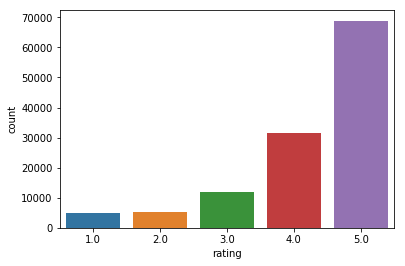

In [19]:
sns.countplot(df_final['rating'])

In [20]:
print("========== Data Distribution on the filtered data set ==========")
print("Unique Products : ", len(df_final['productId'].unique()))
print("Unique Users : ", len(df_final['userId'].unique()))
print("Unique Ratings : ", df_final['rating'].unique())
print("Products count by rating :")
print(df_final['rating'].value_counts())

========== Data Distribution on the filtered data set ==========
Unique Products :  47155
Unique Users :  1466
Unique Ratings :  [3. 1. 4. 5. 2.]
Products count by rating :
5.0    68872
4.0    31480
3.0    11747
2.0     5175
1.0     4897
Name: rating, dtype: int64


# 3. Popularity Based Recommendation

* Recommended products based on ** top MEAN ratings ** (on sub set of data where users rated > 50 times)

In [56]:
df_final.groupby('productId')['rating'].mean().head(10)

productId
0594481813    3.00
0970407998    2.50
0972683275    5.00
1400501466    3.00
1400501520    5.00
1400501776    4.50
1400532620    3.00
1400532655    3.60
140053271X    2.50
1400599997    3.75
Name: rating, dtype: float64

* Recommended products based on ** top MEAN ratings ** (On full data set)

In [55]:
df.groupby('productId')['rating'].mean().sort_values(ascending=False).head(10)

productId
BT008V9J9U    5.0
B0058PPK8Y    5.0
B0058OQ9Q2    5.0
B0058OKSMS    5.0
B0058OHGX2    5.0
B0058O9OR8    5.0
B0058O6O8K    5.0
B0058O6J3A    5.0
B0058O6EXA    5.0
B0058O0CMO    5.0
Name: rating, dtype: float64

* Recommended products based on ** most number of ratings ** (On sub set of data where users rated > 50 times)

In [57]:
df_final.groupby('productId')['rating'].count().sort_values(ascending=False).head(10)

productId
B0088CJT4U    204
B003ES5ZUU    177
B000N99BBC    163
B007WTAJTO    156
B00829TIEK    146
B008DWCRQW    135
B00829THK0    132
B002R5AM7C    127
B004CLYEDC    117
B004T9RR6I    108
Name: rating, dtype: int64

* Recommended products based on ** most number of ratings ** (On full data set)

In [58]:
df.groupby('productId')['rating'].count().sort_values(ascending=False).head(10)

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
B003ELYQGG    11617
B003ES5ZUU    10276
B007R5YDYA     9907
B00622AG6S     9823
B0002L5R78     9487
Name: rating, dtype: int64

# 4. Split the data set

In [21]:
reader = Reader(rating_scale=(1,5))

In [22]:
data = Dataset.load_from_df(df_final[['userId', 'productId', 'rating']], reader)

In [23]:
trainset, testset = train_test_split(data, test_size=0.3)

# 5.1 Building User-User based collaborative model

*** KNNWithMeans using Cosine Similarity ***

In [24]:
knn_cos_algo = KNNWithMeans(k=15, sim_options={'name':'cosine', 'user_based': True})

In [25]:
knn_cos_algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [26]:
test_cos_pred = knn_cos_algo.test(testset)

In [27]:
print("Accuracy Score (Cosine Similarity): ",accuracy.rmse(test_cos_pred, verbose=True))

RMSE: 1.0608
Accuracy Score (Cosine Similarity):  1.0607796710381077


In [28]:
test_cos_pred

[Prediction(uid='AGXV8E7XK9J6H', iid='B0017TFVUW', r_ui=3.0, est=3.907267271597694, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='A10NMELR4KX0J6', iid='B003JFQQ6A', r_ui=5.0, est=4.262491376185409, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2QI2JHSIQ3SN3', iid='B0055ZCXVE', r_ui=5.0, est=4.262491376185409, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1XE3M22N91451', iid='B004BFZHO4', r_ui=4.0, est=4.087231376275861, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='A11EYMH9UV9XG7', iid='B002JMYCTC', r_ui=3.0, est=4.164361227240977, details={'actual_k': 6, 'was_impossible': False}),
 Prediction(uid='A35Q0RBM3YNQNF', iid='B00ISKS402', r_ui=5.0, est=4.705545416542859, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='AS2II0671KT2C', iid='B0092HP3GS', r_ui=3.0, est=4.627450980392157, details={'actual_k': 0, 'was_impossible': False}),


*** KNNWithMeans using Pearson Similarity ***

In [29]:
knn_pearson_algo = KNNWithMeans(k=15, min_k=2, sim_options={'name':'pearson', 'user_based': True})

In [30]:
knn_pearson_algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [31]:
test_pearson_pred = knn_pearson_algo.test(testset)

In [32]:
print("Accuracy Score (Pearson Similarity): ",accuracy.rmse(test_pearson_pred, verbose=True))

RMSE: 1.0261
Accuracy Score (Pearson Similarity):  1.0260656538300723


In [33]:
test_pearson_pred

[Prediction(uid='AGXV8E7XK9J6H', iid='B0017TFVUW', r_ui=3.0, est=4.109090909090909, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A10NMELR4KX0J6', iid='B003JFQQ6A', r_ui=5.0, est=4.262491376185409, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2QI2JHSIQ3SN3', iid='B0055ZCXVE', r_ui=5.0, est=4.262491376185409, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1XE3M22N91451', iid='B004BFZHO4', r_ui=4.0, est=4.475409836065574, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A11EYMH9UV9XG7', iid='B002JMYCTC', r_ui=3.0, est=4.369565217391305, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A35Q0RBM3YNQNF', iid='B00ISKS402', r_ui=5.0, est=4.549019607843137, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AS2II0671KT2C', iid='B0092HP3GS', r_ui=3.0, est=4.627450980392157, details={'actual_k': 0, 'was_impossible': False}),


# 5.2 SVD

In [34]:
svd_algo = SVD()

In [35]:
cv_result = cross_validate(svd_algo, data, measures=['rmse', 'mae'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9862  0.9742  0.9753  0.9826  0.9814  0.9799  0.0045  
MAE (testset)     0.7268  0.7201  0.7216  0.7253  0.7274  0.7242  0.0029  
Fit time          7.40    7.56    8.11    8.57    8.61    8.05    0.50    
Test time         0.36    0.34    0.32    0.29    0.28    0.32    0.03    


In [36]:
rmse = cv_result.get('test_rmse')

In [37]:
print("Accuracy Score(RMSE - SVD) : ",rmse[rmse.argmin()])
print("Accuracy Score(MAE - SVD) : ",cv_result.get('test_mae')[cv_result.get('test_mae').argmin()])

Accuracy Score(RMSE - SVD) :  0.9742288358127519
Accuracy Score(MAE - SVD) :  0.7201303766285236


# 5.3 Building Item-Item based collaborative model

In [38]:
knn_item_algo = KNNWithMeans(k=5, min_k=2, sim_options={'name':'cosine', 'user_based': False})

In [39]:
knn_item_algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [40]:
test_item_pred = knn_item_algo.test(testset)

In [41]:
accuracy.rmse(test_item_pred, verbose=True)

RMSE: 1.1185


1.118491452905315

In [42]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions[0:10]:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

*** Cosine Similarity : Top 5 Prediction ***
* Printed only first 10 records for better readability

In [47]:
get_top_n(test_cos_pred, 5)

defaultdict(list,
            {'AGXV8E7XK9J6H': [('B0017TFVUW', 3.907267271597694)],
             'A10NMELR4KX0J6': [('B003JFQQ6A', 4.262491376185409)],
             'A2QI2JHSIQ3SN3': [('B0055ZCXVE', 4.262491376185409)],
             'A1XE3M22N91451': [('B004BFZHO4', 4.087231376275861)],
             'A11EYMH9UV9XG7': [('B002JMYCTC', 4.164361227240977)],
             'A35Q0RBM3YNQNF': [('B00ISKS402', 4.705545416542859)],
             'AS2II0671KT2C': [('B0092HP3GS', 4.627450980392157)],
             'AFHYEO3Y1IIDD': [('B000087L9H', 4.262491376185409)],
             'A3S0EHEIR52HP1': [('B00CJSOYMG', 4.775862068965517)],
             'A2XQYE6TJYROHQ': [('B003KGBBRW', 4.487804878048781)]})

*** Pearson Similarity : Top 5 Prediction ***
* Printed only first 10 records for better readability

In [48]:
get_top_n(test_pearson_pred,5)

defaultdict(list,
            {'AGXV8E7XK9J6H': [('B0017TFVUW', 4.109090909090909)],
             'A10NMELR4KX0J6': [('B003JFQQ6A', 4.262491376185409)],
             'A2QI2JHSIQ3SN3': [('B0055ZCXVE', 4.262491376185409)],
             'A1XE3M22N91451': [('B004BFZHO4', 4.475409836065574)],
             'A11EYMH9UV9XG7': [('B002JMYCTC', 4.369565217391305)],
             'A35Q0RBM3YNQNF': [('B00ISKS402', 4.549019607843137)],
             'AS2II0671KT2C': [('B0092HP3GS', 4.627450980392157)],
             'AFHYEO3Y1IIDD': [('B000087L9H', 4.262491376185409)],
             'A3S0EHEIR52HP1': [('B00CJSOYMG', 4.775862068965517)],
             'A2XQYE6TJYROHQ': [('B003KGBBRW', 4.487804878048781)]})